## Setup

In [1]:
# Facial image emotion recognition using CNN
# Target classes: Angry, Disgusted, Fearful, Happy, Sad, Surprised, Neutral

import tensorflow as tf

NUM_THREADS = 32

tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

# Switch to GPU
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)


# DATASET
# files in dataset/test and dataset/train
# subfolders: angry, disgusted, fearful, happy, sad, surprised, neutral

# load dataset
train_dir = "dataset/train"
test_dir = "dataset/test"

2024-07-09 18:25:30.598691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 18:25:30.622521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 18:25:30.622556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 18:25:30.638693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 18:25:31.405608: W tensorflow/com

Num GPUs Available:  2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# Test data
# Check for the number of images in each class and the size of the images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"  # 0 = alle Meldungen werden ausgegeben

# List of classes
classes = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# Number of images in each class
print("Number of training images in each class:")
for c in classes:
    path = os.path.join(train_dir, c)
    print(f"{c}: {len(os.listdir(path))} images")

print("\nNumber of test images in each class:")
for c in classes:
    path = os.path.join(test_dir, c)
    print(f"{c}: {len(os.listdir(path))} images")

# Image size
img = cv2.imread("dataset/train/angry/Training_3908.jpg")
print(f"\nImage size: {img.shape}")

input_shape = img.shape

# Reduce image size to 48x48 pixels due to greyscale (original size: 48x48x3)
input_shape = (48, 48, 1)

Number of training images in each class:
angry: 4162 images
disgust: 411 images
fear: 4171 images
happy: 7628 images
sad: 5073 images
surprise: 2842 images
neutral: 5248 images

Number of test images in each class:
angry: 939 images
disgust: 84 images
fear: 982 images
happy: 1850 images
sad: 1270 images
surprise: 610 images
neutral: 1255 images

Image size: (48, 48, 3)


## Loading the images from disk

In [62]:
import dataloader

greyscale = True
augmentation = None

train_ds, test_ds = dataloader.load(
    train_dir, test_dir, 7, OneChannelOnly=greyscale, augmentations=augmentation
)

Found 29535 files belonging to 7 classes.
Found 6990 files belonging to 7 classes.


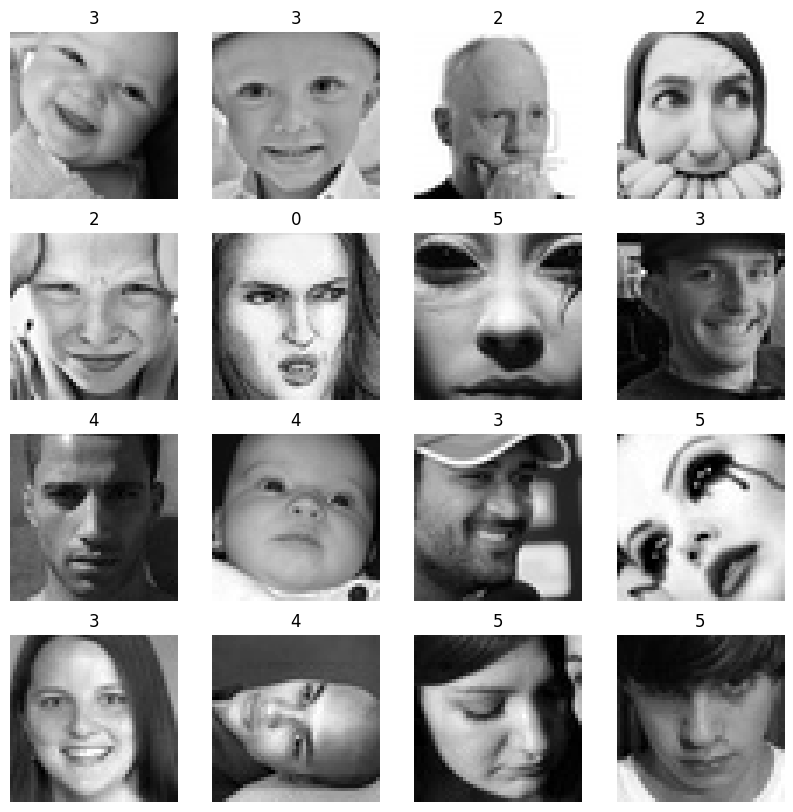

2024-07-09 18:59:18.693753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Show the first 16 images and their labels
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        if greyscale:
            plt.imshow(np.squeeze(images[i]), cmap="gray")
        else:
            plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))
        plt.axis("off")
    plt.show()

Image shape: (64, 48, 48, 1), Label dtype: <dtype: 'float32'>
Image dtype: <dtype: 'float32'>, Label dtype: <dtype: 'float32'>


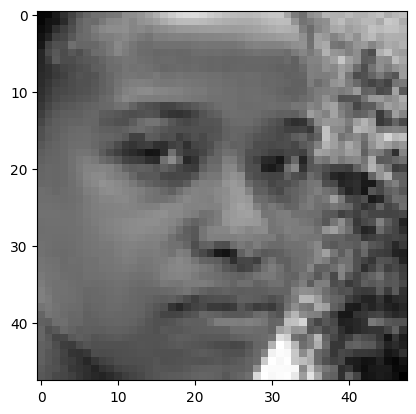

2024-07-09 18:59:27.009849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [64]:
# Print one image (to confirm whether the images are represented as 48x48x1 tensors)
for img, label in train_ds.take(1):
    print(f"Image shape: {img.shape}, Label dtype: {label.dtype}")
    print(f"Image dtype: {img.dtype}, Label dtype: {label.dtype}")

    # Plot the image
    if greyscale:
        plt.imshow(np.squeeze(img[0]), cmap="gray")
    else:
        plt.imshow(img[0])
    plt.show()

## Class distribution and weights

2024-07-09 18:59:32.286111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Class Distribution: Counter({3: 1850, 5: 1270, 4: 1255, 2: 982, 0: 939, 6: 610, 1: 84})
Test Class Distribution: Counter({3: 7628, 4: 5248, 5: 5073, 2: 4171, 0: 4162, 6: 2842, 1: 411})


2024-07-09 18:59:32.631048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


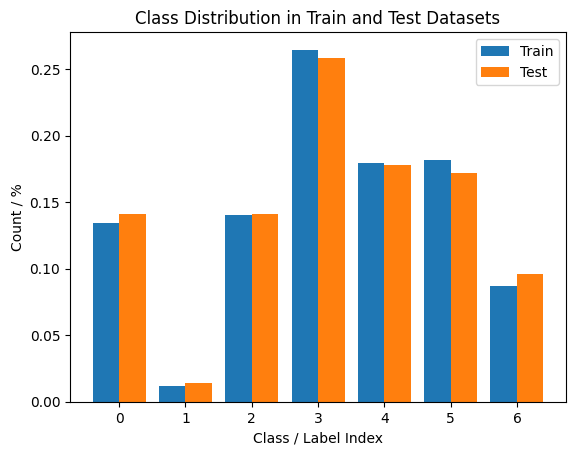

In [65]:
import collections


def get_class_distribution(dataset):
    class_counts = collections.Counter()

    for _, label_batch in dataset:
        labels = tf.argmax(label_batch, axis=1)
        class_counts.update(labels.numpy())

    return class_counts


# Klassenverteilung im Trainingsdatensatz
train_class_distribution = get_class_distribution(train_ds)
print("Train Class Distribution:", train_class_distribution)

# Klassenverteilung im Testdatensatz
test_class_distribution = get_class_distribution(test_ds)
print("Test Class Distribution:", test_class_distribution)


def plot_class_distributions(train_distribution, test_distribution):
    classes = sorted(
        set(train_distribution.keys()).union(set(test_distribution.keys()))
    )

    train_counts = [train_distribution[cls] for cls in classes]
    test_counts = [test_distribution[cls] for cls in classes]

    width = 0.4  # width of the bars
    x = range(len(classes))  # the label locations

    fig, ax = plt.subplots()

    ax.bar(x, train_counts, width, label="Train", align="center")
    ax.bar([p + width for p in x], test_counts, width, label="Test", align="center")

    ax.set_xlabel("Class / Label Index")
    ax.set_ylabel("Count / %")
    ax.set_title("Class Distribution in Train and Test Datasets")
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(classes)
    ax.legend()

    plt.show()


train_total = sum(train_class_distribution.values())
test_total = sum(test_class_distribution.values())

train_class_distribution = {
    k: v / train_total for k, v in train_class_distribution.items()
}
test_class_distribution = {
    k: v / test_total for k, v in test_class_distribution.items()
}

plot_class_distributions(train_class_distribution, test_class_distribution)

In [51]:
import sklearn
from sklearn.utils import class_weight

# Load labels as vector
y_train = []
for i, c in enumerate(classes):
    path = os.path.join(train_dir, c)
    for img_name in os.listdir(path):
        if img is not None:  # Ensure the image was read correctly
            y_train.append(i)

In [53]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)

# Nehme an, y_train_labels sind die Labels deiner Trainingsdaten
y_train_labels = np.argmax(y_train_encoded, axis=1)
y_train_labels = y_train_labels.astype(np.int32)

# Berechnung der Klassengewichte
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels
)

# Convert the class weights to a dictionary. Use np.int32 as the key type
class_weights_dict = {
    int(k): float(v) for k, v in zip(np.unique(y_train_labels), class_weights)
}

print("Class weights:", class_weights_dict)
# Print the type of keys in the dictionary
print("Type of keys:", type(list(class_weights_dict.keys())[0]))
# Print the type of values in the dictionary
print("Type of values:", type(list(class_weights_dict.values())[0]))

Class weights: {0: 1.0137639870941169, 1: 10.265901981230448, 2: 1.0115765318354626, 3: 0.5531313206981796, 4: 0.8317141167525556, 5: 1.4846184779330451, 6: 0.8039797473867596}
Type of keys: <class 'int'>
Type of values: <class 'float'>


In [54]:
# Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=50, restore_best_weights=True, mode="max"
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, patience=20, min_lr=0.00001, mode="max"
)

## Preparing the model

In [71]:
import densenet
from tensorflow.keras import optimizers

input_shape = (48, 48, 1)
num_blocks = 4
num_layers_per_block = [6, 12, 24, 16]  # DenseNet-121 configuration
growth_rate = 32
reduction = 0.5
num_classes = 7

model = densenet.DenseNet(
    num_blocks,
    num_layers_per_block,
    growth_rate,
    reduction,
    num_classes,
    input_shape,
)
model.build((None, *input_shape))
model.compile(
    optimizer=optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model(tf.keras.Input(input_shape))
model.summary()

/data/hagemann/ml/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'dense_net_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "dense_net_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_366 (Conv2D)             │ (None, 24, 24, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_372         │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_366 (ReLU)                │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_1 (DenseBlock)      │ ?                      │       338,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_1              │ ?                      │        33,792 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_2 (DenseBlock)      │ ?                      │       930,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_2              │ ?                      │       133,120 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_3 (DenseBlock)      │ ?                      │     2,873,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_3              │ ?                      │       528,384 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_4 (DenseBlock)      │ ?                      │     2,186,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_489         │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_483 (ReLU)                │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,407 (26.85 MB)

 Trainable params: 6,954,759 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

## Training & Evaluation

In [72]:
history = model.fit(
    train_ds,
    class_weight=class_weights_dict,
    epochs=200,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/200


I0000 00:00:1720544753.405980   46742 service.cc:145] XLA service 0x7f2e54046660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720544753.406097   46742 service.cc:153]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1720544753.406111   46742 service.cc:153]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2024-07-09 19:05:54.658346: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-09 19:05:59.033770: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1720544787.576568   46742 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduc

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.1757 - loss: 1.9420

I0000 00:00:1720544820.135864   46741 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_66', 16 bytes spill stores, 16 bytes spill loads



110/110 ━━━━━━━━━━━━━━━━━━━━ 115s 464ms/step - accuracy: 0.1758 - loss: 1.9422 - val_accuracy: 0.1718 - val_loss: 1.9419 - learning_rate: 0.0010
Epoch 2/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.1799 - loss: 1.9226 - val_accuracy: 0.1718 - val_loss: 1.9309 - learning_rate: 0.0010
Epoch 3/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.1796 - loss: 1.9066 - val_accuracy: 0.1718 - val_loss: 1.9274 - learning_rate: 0.0010
Epoch 4/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.1821 - loss: 1.9056 - val_accuracy: 0.1718 - val_loss: 1.9320 - learning_rate: 0.0010
Epoch 5/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.1825 - loss: 1.8956 - val_accuracy: 0.1705 - val_loss: 1.9228 - learning_rate: 0.0010
Epoch 6/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.1804 - loss: 1.9084 - val_accuracy: 0.1718 - val_loss: 1.9409 - learning_rate: 0.0010
Epoch 7/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.1795 

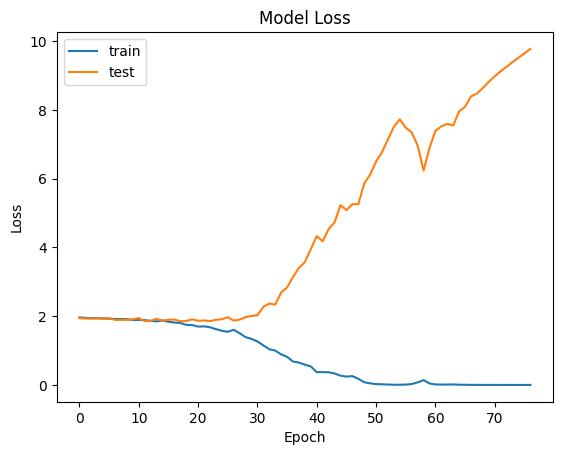

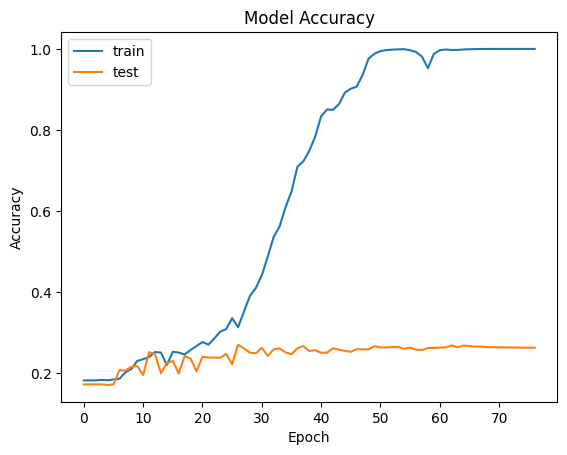

In [73]:
# Plot training history (loss and accuracy)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [74]:
# Load test data
x_test = []
y_test = []

for i, c in enumerate(classes):
    path = os.path.join(test_dir, c)
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            if greyscale:
                img = cv2.resize(img, (48, 48))
                # Image to greyscale and shape (48, 48, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = np.expand_dims(
                    img, axis=-1
                )  # Add channel dimension for greyscale images
            # Normalize the image
            img = img / 255.0
            x_test.append(img)
            y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Bruh, why you taking so long..

y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)

# Print one image as matrix
print(x_test[0].shape)
print(type(x_test))
print(x_test[0])

(48, 48, 1)
<class 'numpy.ndarray'>
[[[0.69803922]
  [0.72941176]
  [0.76470588]
  ...
  [0.83137255]
  [0.90980392]
  [0.88627451]]

 [[0.66666667]
  [0.70588235]
  [0.74509804]
  ...
  [0.81568627]
  [0.87843137]
  [0.90196078]]

 [[0.72941176]
  [0.71764706]
  [0.70588235]
  ...
  [0.85882353]
  [0.83137255]
  [0.84313725]]

 ...

 [[0.84313725]
  [0.85490196]
  [0.8627451 ]
  ...
  [0.81568627]
  [0.82745098]
  [0.83921569]]

 [[0.86666667]
  [0.84705882]
  [0.85098039]
  ...
  [0.80784314]
  [0.80784314]
  [0.82745098]]

 [[0.83921569]
  [0.83921569]
  [0.85490196]
  ...
  [0.81568627]
  [0.80392157]
  [0.82352941]]]


In [75]:
# As a test, print one image from the training set
print(train_ds.take(1))
for img, label in train_ds.take(1):
    print(img[0])
    print(label[0])

<_TakeDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>
tf.Tensor(
[[[0.00392157]
  [0.00392157]
  [0.00392157]
  ...
  [0.04705882]
  [0.53333336]
  [0.84705883]]

 [[0.        ]
  [0.        ]
  [0.00392157]
  ...
  [0.05490196]
  [0.54901963]
  [0.8509804 ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.05098039]
  [0.54901963]
  [0.84705883]]

 ...

 [[0.01176471]
  [0.        ]
  [0.        ]
  ...
  [0.12156863]
  [0.02745098]
  [0.05490196]]

 [[0.03529412]
  [0.00392157]
  [0.        ]
  ...
  [0.08627451]
  [0.03137255]
  [0.06666667]]

 [[0.03529412]
  [0.        ]
  [0.00392157]
  ...
  [0.05098039]
  [0.09411765]
  [0.07058824]]], shape=(48, 48, 1), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)


2024-07-10 10:30:20.980160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model saved as emotion_recognition_model.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.2738 - loss: 1.7470
[2.0542118549346924, 0.2226037234067917]
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.21      0.26       939
           1       0.17      0.71      0.28        84
           2       0.33      0.26      0.29       982
           3       0.47      0.44      0.46      1850
           4       0.11      0.06      0.08      1270
           5       0.03      0.13      0.05       610
           6       0.11      0.05      0.07      1255

    accuracy                           0.22      6990
   macro avg       0.23      0.27      0.21      6990
weighted avg       0.26      0.22      0.23      6990

Confusion Matrix:
 [[197  31 108 183  61 313  46]
 [  0  60   2   4  10   8   0]
 [ 83  46 258 147  76 275  97]
 [106  84 120 823 138 518  61]
 [ 60  58  81 183  80 764  44]


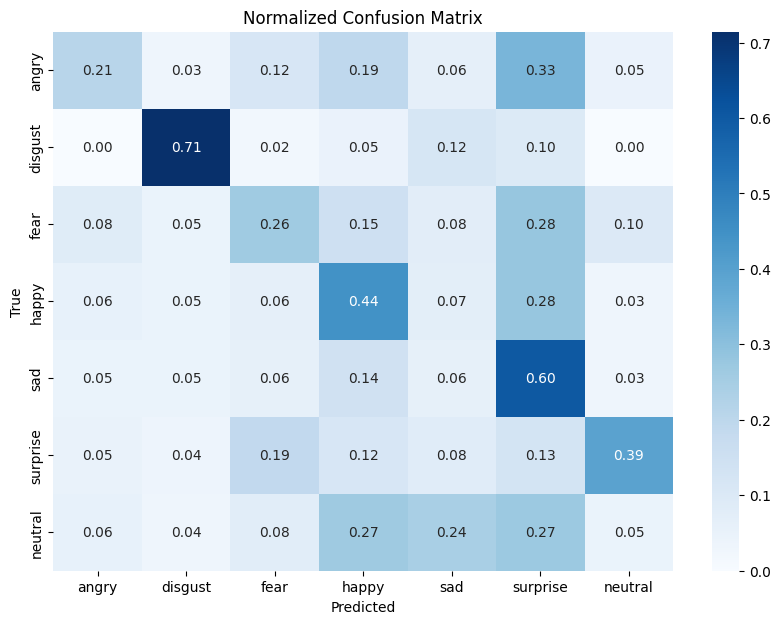

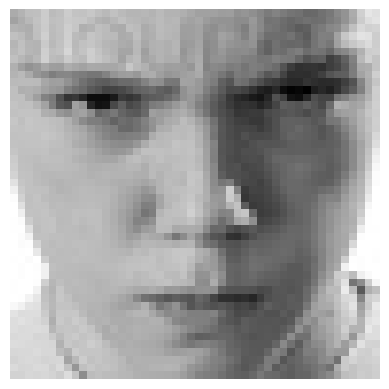

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted emotion: angry


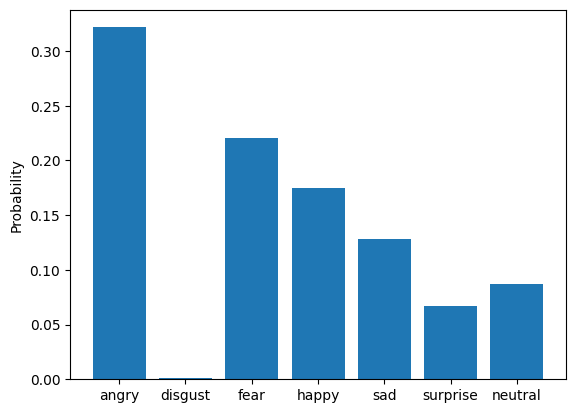

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


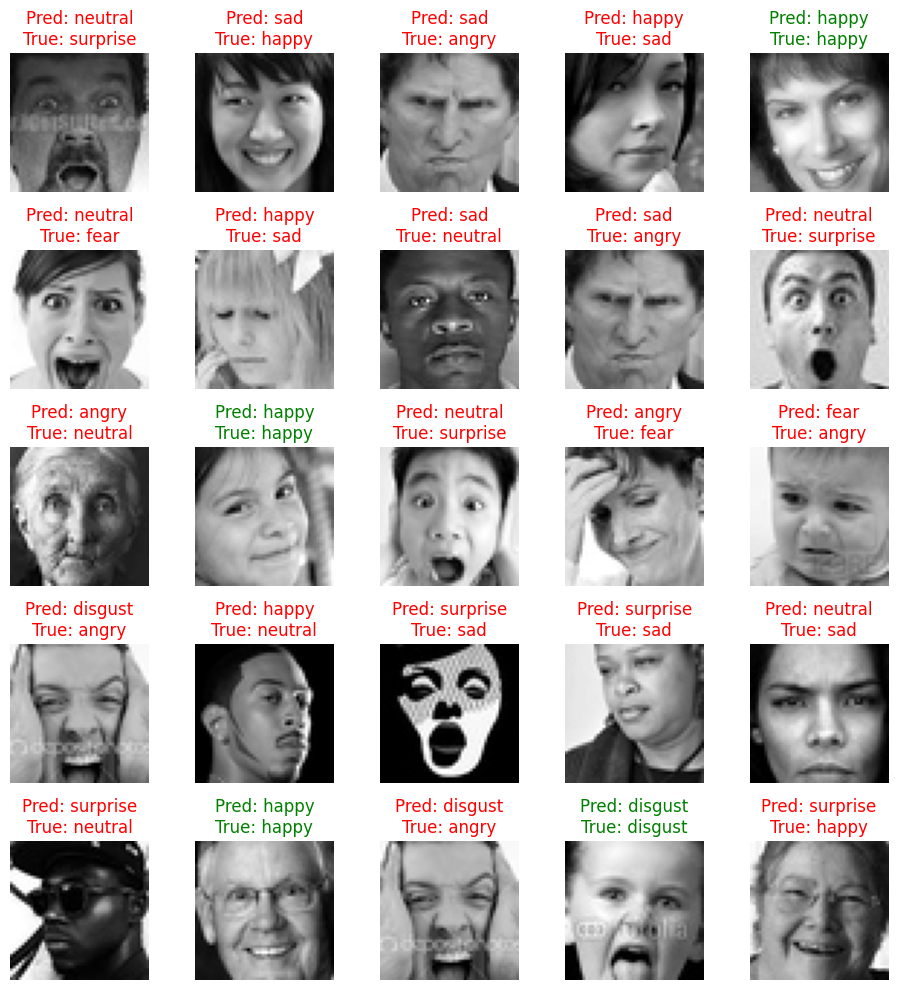

In [77]:
# if history is not None:

#     # PLOT TRAINING AND VALIDATION ACCURACY
#     plt.plot(history.history['accuracy'], label='accuracy')
#     plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='lower right')
#     plt.show()

#     # PLOT TRAINING AND VALIDATION LOSS
#     plt.plot(history.history['loss'], label='loss')
#     plt.plot(history.history['val_loss'], label = 'val_loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend(loc='upper right')
#     plt.show()

#     # Zugreifen auf die Metriken im Trainingsverlauf
#     accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']

#     # Beispielausgabe der Genauigkeit
#     print("Training Accuracy:", accuracy)
#     print("Validation Accuracy:", val_accuracy)


# SAVE MODEL, if model is defined

if model is not None:
    model.save("emotion_recognition_model.h5")
    print("Model saved as emotion_recognition_model.h5")
else:
    # Load model
    model = tf.keras.models.load_model("emotion_recognition_model.h5")
    print("Model loaded from emotion_recognition_model.h5")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate model
evaluation = model.evaluate(x_test, y_test_encoded)

# print evaluation
print(evaluation)

# Predict test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Display normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    xticklabels=classes,
    yticklabels=classes,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# TEST MODEL
# Load test image
file_path = "dataset_RAF_DB/test/angry/test_0037_aligned.jpg"
img = x_test[0]

# Display image (back to original size)
img = np.reshape(img, [48, 48])
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

img = x_test[0]
img = np.reshape(img, [1, 48, 48, 1])
# Predict emotion
prediction = model.predict(img)
emotion = classes[np.argmax(prediction)]
print(f"Predicted emotion: {emotion}")

# Display prediction
plt.bar(classes, prediction[0])
plt.ylabel("Probability")
plt.show()

# 5x5 matrix with random pictures from the test set, labeled with the predicted emotion and the true emotion; text color is green if the prediction is correct, red otherwise
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    index = random.randint(0, len(x_test) - 1)
    img = x_test[index]
    img = np.reshape(img, [1, 48, 48, 1])
    prediction = model.predict(img)
    emotion = classes[np.argmax(prediction)]
    true_emotion = classes[y_test[index]]
    color = "g" if emotion == true_emotion else "r"
    # Image back to original size
    img = x_test[index]
    img = np.reshape(img, [48, 48])
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {emotion}\nTrue: {true_emotion}", color=color)
    plt.axis("off")
    plt.tight_layout()

plt.show()